### import Library

In [17]:
import os
import sys
import time
import matplotlib
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Multiply, \
    BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import seaborn as sns

### Library Version

In [3]:
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(tf.__version__)
print(keras.__version__)

1.2.4
1.21.5
3.5.1
1.3.2
2.6.0
2.6.0


In [4]:
cols = """duration,
protocol_type,
service,
flag,
src_bytes,
dst_bytes,
land,
wrong_fragment,
urgent,
hot,
num_failed_logins,
logged_in,
num_compromised,
root_shell,
su_attempted,
num_root,
num_file_creations,
num_shells,
num_access_files,
num_outbound_cmds,
is_host_login,
is_guest_login,
count,
srv_count,
serror_rate,
srv_serror_rate,
rerror_rate,
srv_rerror_rate,
same_srv_rate,
diff_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_srv_count,
dst_host_same_srv_rate,
dst_host_diff_srv_rate,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,
dst_host_rerror_rate,
dst_host_srv_rerror_rate"""

columns = [c.strip() for c in cols.split(',') if c.strip()]
columns.append('target')

In [5]:
attacks_types = {
    'normal': 'normal',
    'back': 'dos', 'neptune': 'dos', 'smurf': 'dos', 'teardrop': 'dos', 'land': 'dos', 'pod': 'dos', 'apache2': 'dos',
    'mailbomb': 'dos', 'processtable': 'dos', 'udpstorm': 'dos',
    'satan': 'probe', 'portsweep': 'probe', 'ipsweep': 'probe', 'nmap': 'probe', 'mscan': 'probe', 'saint': 'probe',
    'warezmaster': 'r2l', 'warezclient': 'r2l', 'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l',
    'multihop': 'r2l', 'phf': 'r2l', 'spy': 'r2l', 'sendmail': 'r2l', 'named': 'r2l', 'snmpgetattack': 'r2l',
    'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'r2l',
    'rootkit': 'u2r', 'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'httptunnel': 'u2r', 'ps': 'u2r',
    'sqlattack': 'u2r', 'xterm': 'u2r'
}

In [6]:
def Pre_Handle_Data(file_name, columns, attacks_types):
    df = pd.read_csv(file_name, names=columns)
    df['Attack Type'] = df.target.apply(lambda r: attacks_types[r[:-1]])

    df.drop('num_root', axis=1, inplace=True)
    df.drop('srv_serror_rate', axis=1, inplace=True)
    df.drop('srv_rerror_rate', axis=1, inplace=True)
    df.drop('dst_host_srv_serror_rate', axis=1, inplace=True)
    df.drop('dst_host_serror_rate', axis=1, inplace=True)
    df.drop('dst_host_rerror_rate', axis=1, inplace=True)
    df.drop('dst_host_srv_rerror_rate', axis=1, inplace=True)
    df.drop('dst_host_same_srv_rate', axis=1, inplace=True)
    df.drop('is_host_login', axis=1, inplace=True)

    df = df.dropna(axis=1, how='any')

    df = df[[col for col in df if df[col].nunique() > 1]]

    lable_map = {'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}
    protocol_map = {'icmp': 0, 'tcp': 1, 'udp': 2}
    flag_map = {'SF': 0, 'S0': 1, 'REJ': 2, 'RSTR': 3, 'RSTO': 4, 'SH': 5, 'S1': 6, 'S2': 7, 'RSTOS0': 8, 'S3': 9,
                'OTH': 10}
    service_map = {'aol': 0, 'auth': 1, 'bgp': 2, 'courier': 3, 'csnet_ns': 4, 'ctf': 5, 'daytime': 6, 'discard': 7,
                   'domain': 8, 'domain_u': 9, 'echo': 10, 'eco_i': 11, 'ecr_i': 12, 'efs': 13, 'exec': 14,
                   'finger': 15,
                   'ftp': 16, 'ftp_data': 17, 'gopher': 18, 'harvest': 19, 'hostnames': 20, 'http': 21, 'http_2784': 22,
                   'http_443': 23, 'http_8001': 24, 'imap4': 25, 'IRC': 26, 'iso_tsap': 27, 'klogin': 28, 'kshell': 29,
                   'ldap': 30, 'link': 31, 'login': 32, 'mtp': 33, 'name': 34, 'netbios_dgm': 35, 'netbios_ns': 36,
                   'netbios_ssn': 37, 'netstat': 38, 'nnsp': 39, 'nntp': 40, 'ntp_u': 41, 'other': 42, 'pm_dump': 43,
                   'pop_2': 44, 'pop_3': 45, 'printer': 46, 'private': 47, 'red_i': 48, 'remote_job': 49, 'rje': 50,
                   'shell': 51, 'smtp': 52, 'sql_net': 53, 'ssh': 54, 'sunrpc': 55, 'supdup': 56, 'systat': 57,
                   'telnet': 58,
                   'tftp_u': 59, 'tim_i': 60, 'time': 61, 'urh_i': 62, 'urp_i': 63, 'uucp': 64, 'uucp_path': 65,
                   'vmnet': 66,
                   'whois': 67, 'X11': 68, 'Z39_50': 69}

    df['protocol_type'] = df['protocol_type'].map(protocol_map)
    df['flag'] = df['flag'].map(flag_map)
    df['Attack Type'] = df['Attack Type'].map(lable_map)
    df['service'] = df['service'].map(service_map)

    df.drop('service', axis=1, inplace=True)

    df = df.drop(['target', ], axis=1)

    return df

In [7]:
from imblearn.over_sampling import SMOTE

file_name = "./Dataset/kddcup.data_10_percent_corrected"

df = Pre_Handle_Data(file_name=file_name, columns=columns, attacks_types=attacks_types)


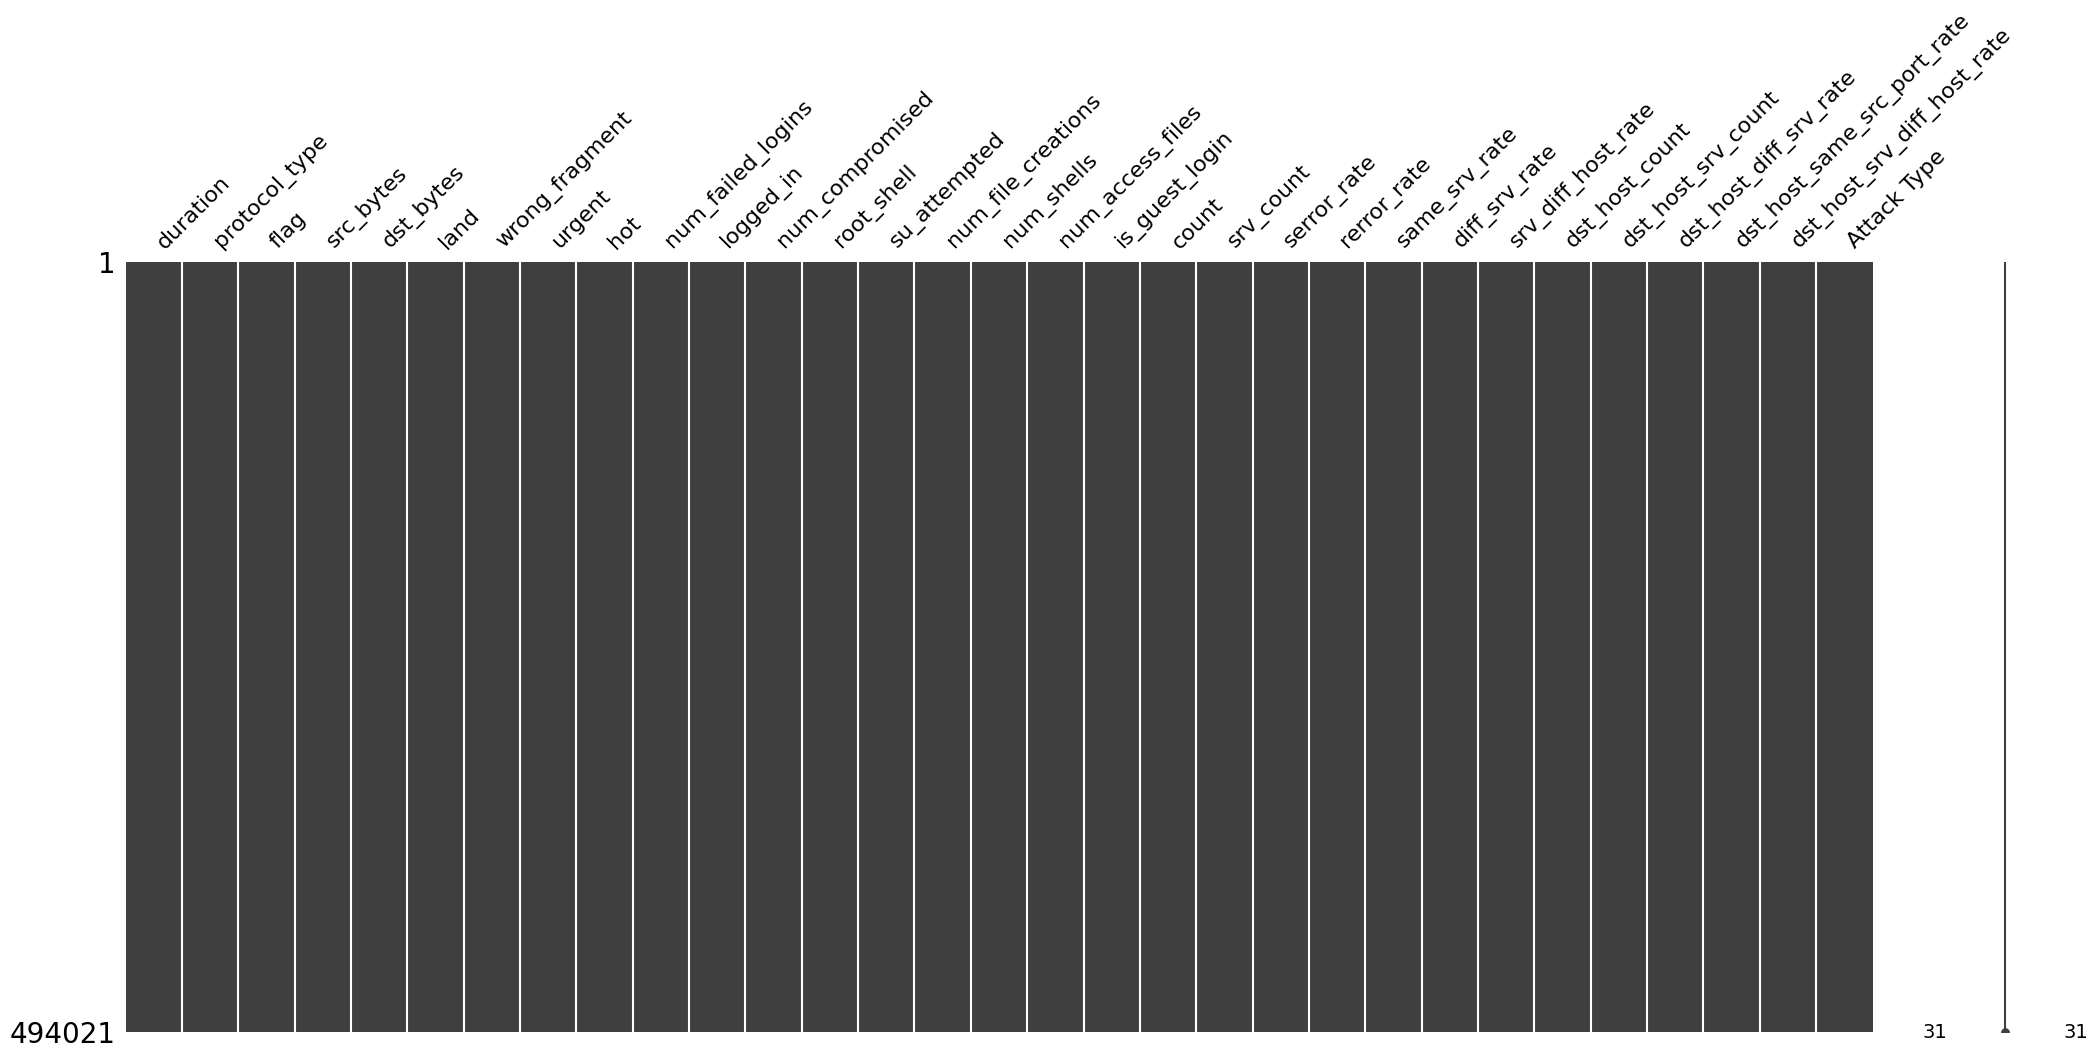

In [8]:
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df)
plt.show()

In [9]:
Y = df[['Attack Type']]
X = df.drop(['Attack Type', ], axis=1)

sc = MinMaxScaler()
X = sc.fit_transform(X)

print(X.shape, Y.shape)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)

smote = SMOTE(random_state=42)

X_train, Y_train = smote.fit_resample(X_train, Y_train)
print(X_val.shape, Y_val.shape)
print(X_train.shape, Y_train.shape)


(494021, 30) (494021, 1)
(163027, 30) (163027, 1)
(1311760, 30) (1311760, 1)


### Machince Learning

In [10]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, Y_train.values.ravel())

y_test_pred = gnb.predict(X_train)

print("Train score is:", gnb.score(X_train, Y_train))
print("Test score is:", gnb.score(X_val, Y_val))

Train score is: 0.7926434713667134
Test score is: 0.8786397345225024


In [11]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)

dtc.fit(X_train, Y_train.values.ravel())

y_test_pred = dtc.predict(X_train)

print("Train score is:", dtc.score(X_train, Y_train))
print("Test score is:", dtc.score(X_val, Y_val))


Train score is: 0.9429171494785632
Test score is: 0.9533083476970072


In [13]:
from sklearn.ensemble import RandomForestClassifier

rfst = RandomForestClassifier(n_estimators = 30)

rfst.fit(X_train, Y_train.values.ravel())

y_test_pred = rfst.predict(X_train)

print("Train score is:", rfst.score(X_train, Y_train))
print("Test score is:", rfst.score(X_val, Y_val))

Train score is: 0.9999900896505458
Test score is: 0.999662632570065


In [ ]:
from sklearn.svm import SVC

svc = SVC(gamma = 'scale')

svc.fit(X_train, Y_train.values.ravel())

y_test_pred = svc.predict(X_train)

print("Train score is:", svc.score(X_train, Y_train))
print("Test score is:", svc.score(X_val, Y_val))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1200000)

lr.fit(X_train, Y_train.values.ravel())

y_test_pred = lr.predict(X_train)

print("Train score is:", lr.score(X_train, Y_train))
print("Test score is:", lr.score(X_val, Y_val))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state = 0)

gbc.fit(X_train, Y_train.values.ravel())

y_test_pred = gbc.predict(X_train)

print("Train score is:", gbc.score(X_train, Y_train))
print("Test score is:", gbc.score(X_val, Y_val))

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=50, random_seed=42, learning_rate=0.5, custom_loss=['AUC', 'Accuracy'])

clf.fit(X_train, Y_train, plot=True)

y_test_pred = clf.predict(X_train)

print("Train score is:", clf.score(X_train, Y_train))
print("Test score is:", clf.score(X_val, Y_val))

In [ ]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()

lgbm.fit(X_train, Y_train.values.ravel())

y_test_pred = lgbm.predict(X_train)

print("Train score is:", lgbm.score(X_train, Y_train))
print("Test score is:", lgbm.score(X_val, Y_val))

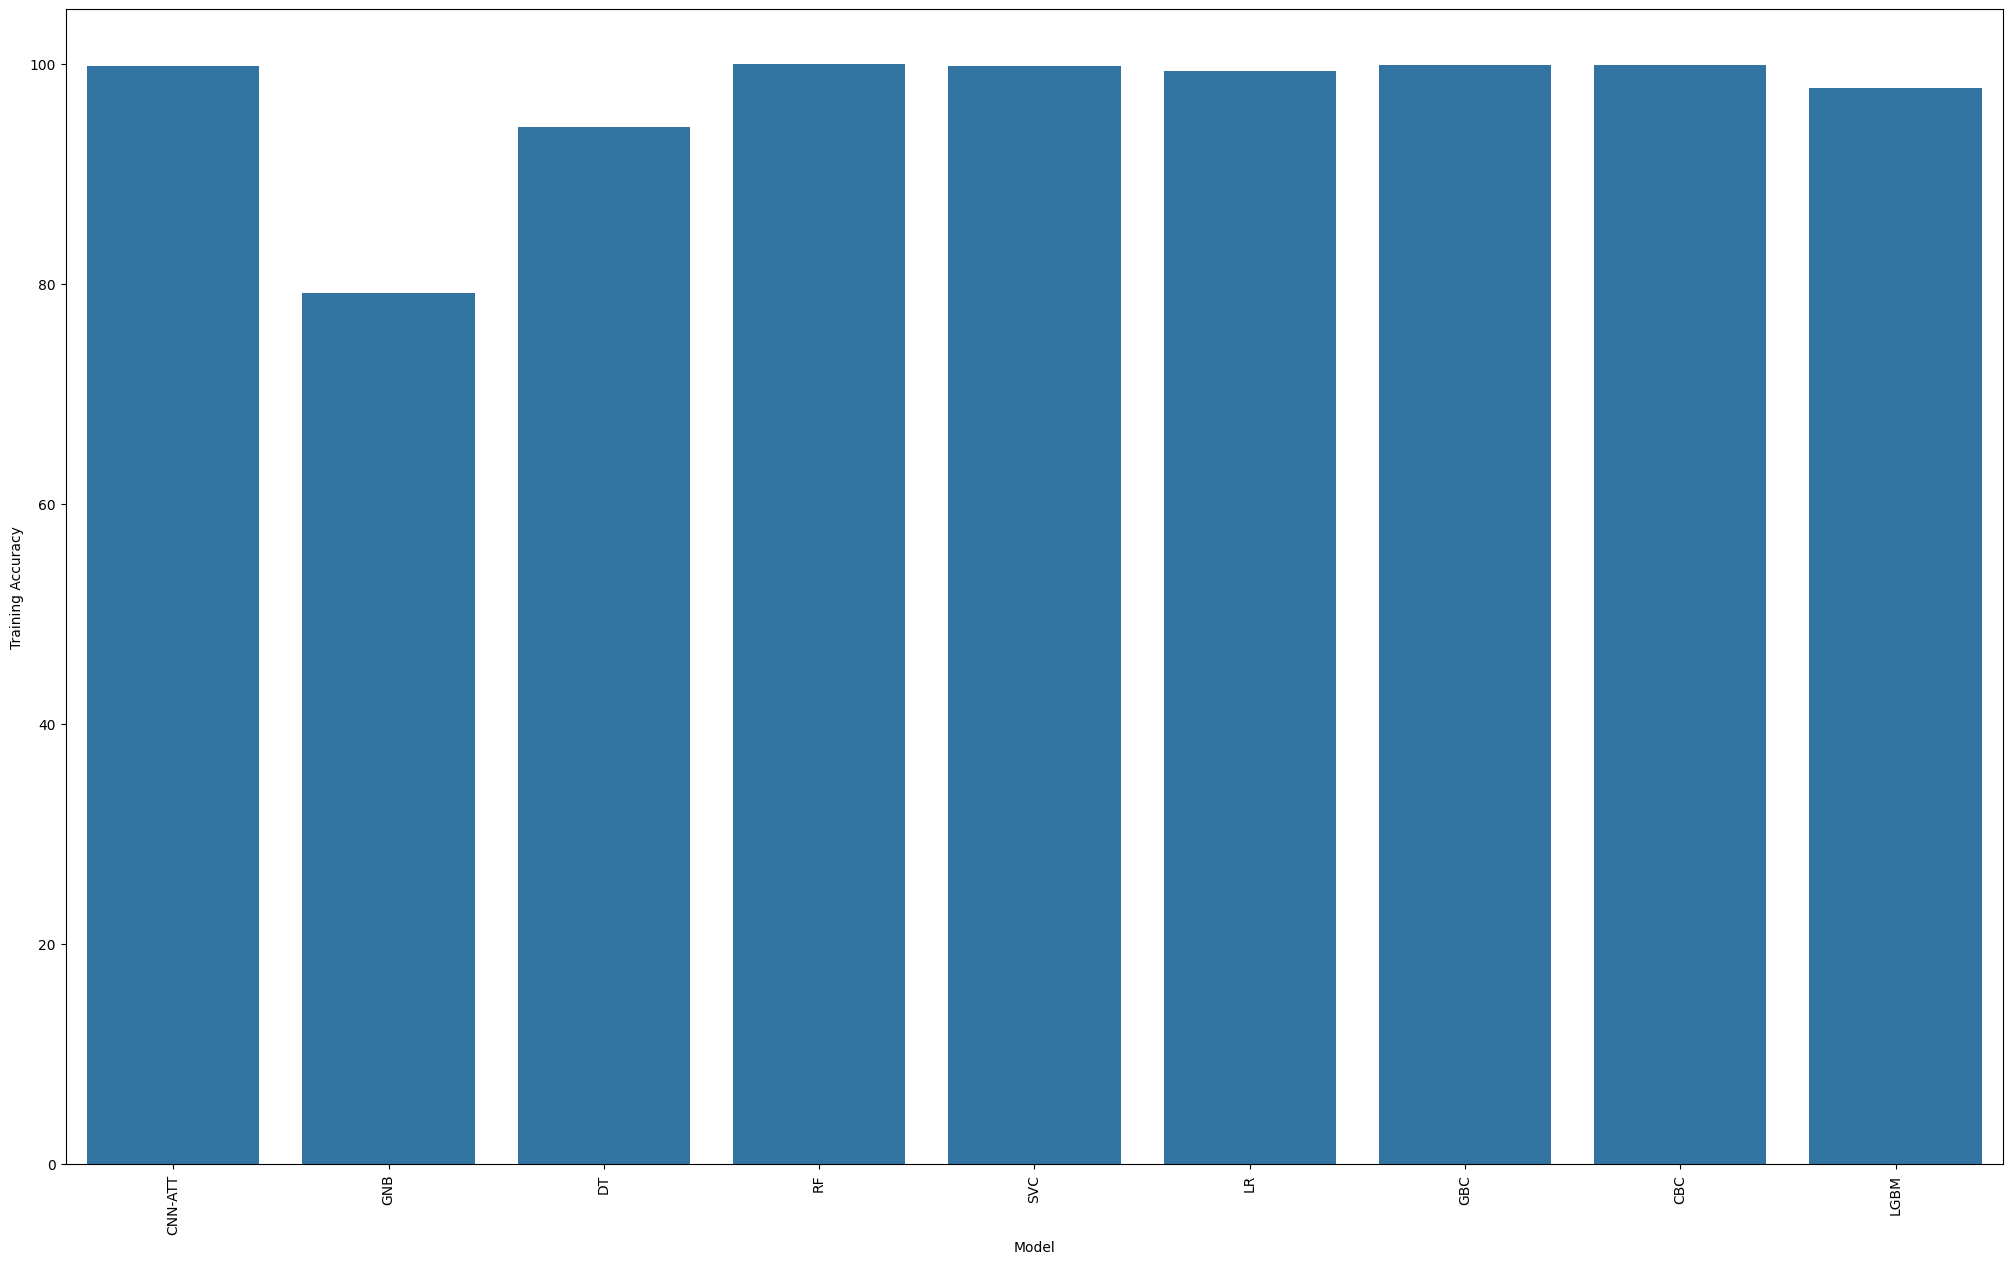

In [18]:
names = ['CNN-ATT', 'GNB', 'DT', 'RF', 'SVC', 'LR', 'GBC', 'CBC', 'LGBM']
values = [99.820, 79.264, 94.291, 99.999, 99.878, 99.409, 99.911, 99.974, 97.856]

plt.figure(figsize=(25,15))
sns.barplot(x=names, y=values)
plt.xticks(rotation= 90)
plt.xlabel('Model')
plt.ylabel('Training Accuracy')
plt.show()

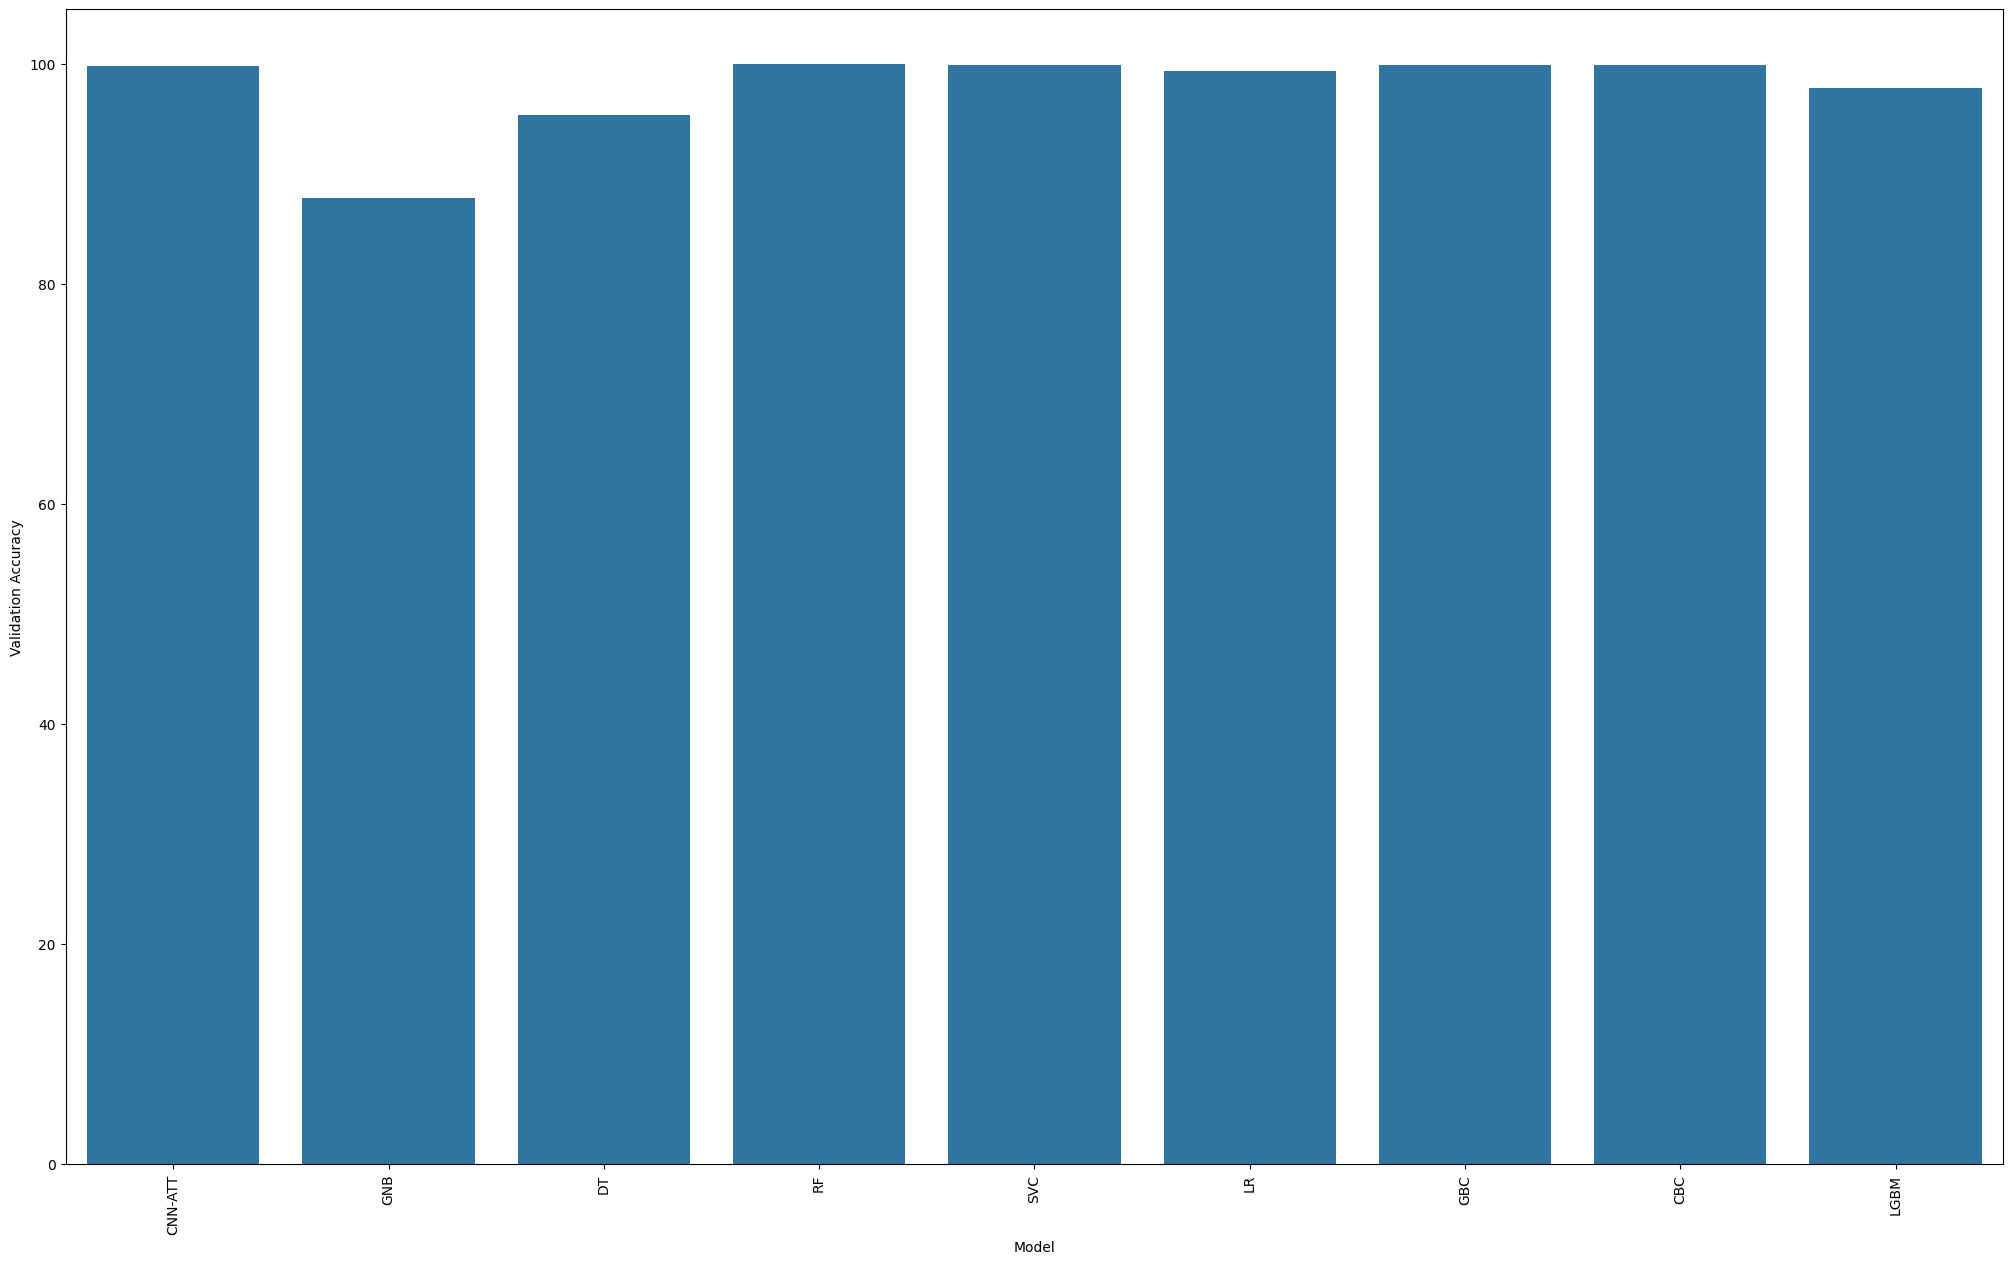

In [19]:
names = ['CNN-ATT', 'GNB', 'DT', 'RF', 'SVC', 'LR', 'GBC', 'CBC', 'LGBM']
values = [99.860, 87.863, 95.330, 99.966, 99.873, 99.413, 99.883, 99.959, 97.802]

plt.figure(figsize=(25,15))
sns.barplot(x=names, y=values)
plt.xticks(rotation= 90)
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.show()

### CNN

In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, BatchNormalization, Activation, \
    LayerNormalization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import datetime
from time import time_ns

input_layer = Input(shape=(X_train.shape[1], Y_val.shape[1]))
conv_layer1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
pool_layer1 = MaxPooling1D(pool_size=2,padding='same')(conv_layer1)
conv_layer2 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(pool_layer1)
pool_layer2 = MaxPooling1D(pool_size=2,padding='same')(conv_layer2)
flatten_layer = layers.Flatten()(pool_layer2)
dense_layer1 = Dense(units=1024, activation='relu')(flatten_layer)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
output_layer = Dense(5, activation='softmax')(dense_layer2)

cnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_model.summary()

cnn_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn_history = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), callbacks=[tensorboard_callback, early_stopping])

cnn_model.save('cnn_model.h5')


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 30, 64)            256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 15, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 15, 128)           24704     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              1049

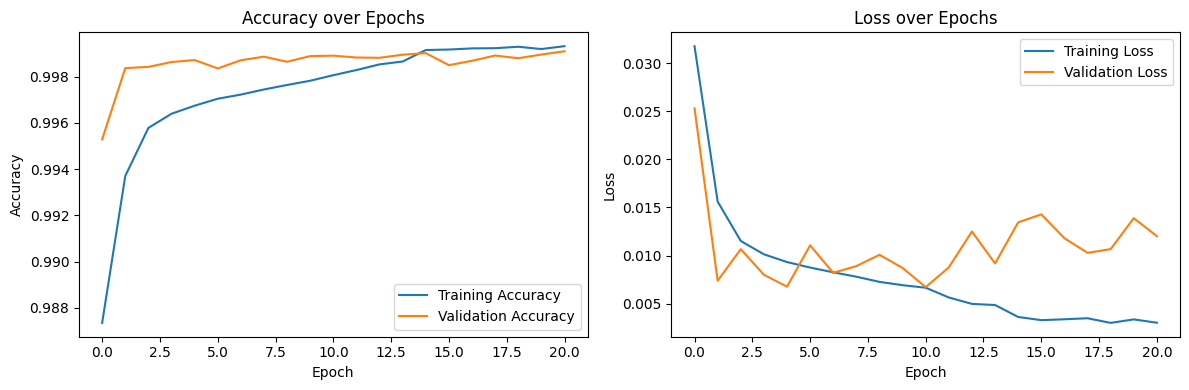

In [17]:
import matplotlib.pyplot as plt


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


plot_history(cnn_history)

### CNN-Attention

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, BatchNormalization, Activation, \
    LayerNormalization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import datetime
from time import time_ns


def multi_head_self_attention(inputs, d_model=128, num_heads=8, dropout_rate=0.1):
        
    assert d_model % num_heads == 0

    dim_per_head = d_model // num_heads

    qkv_linear = Dense(d_model * 3)
    qkv = qkv_linear(inputs)
    q, k, v = tf.split(qkv, 3, axis=-1)

    q = tf.concat(tf.split(q, num_heads, axis=2), axis=0)
    k = tf.concat(tf.split(k, num_heads, axis=2), axis=0)
    v = tf.concat(tf.split(v, num_heads, axis=2), axis=0)

    attention_scores = tf.matmul(q, k, transpose_b=True)
    attention_scores = attention_scores / tf.math.sqrt(tf.cast(dim_per_head, tf.float32))

    attention_probs = tf.nn.softmax(attention_scores, axis=-1)

    attention_probs = Dropout(dropout_rate, name="dropout_attn")(attention_probs)

    context_layer = tf.matmul(attention_probs, v)
    context_layer = tf.concat(tf.split(context_layer, num_heads, axis=0), axis=2)

    out_proj = Dense(d_model, name="dense_attn")
    outputs = out_proj(context_layer)

    return outputs


input_layer = Input(shape=(X_train.shape[1], Y_val.shape[1]))

conv_layer1 = Conv1D(64, 3, padding="same")(input_layer)
bn_layer1 = BatchNormalization()(conv_layer1)
active_layer1 = Activation("relu")(bn_layer1)
pool_layer1 = MaxPooling1D(pool_size=2, padding="same")(active_layer1)

conv_layer2 = Conv1D(128, 3, padding="same")(pool_layer1)
bn_layer2 = BatchNormalization()(conv_layer2)
active_layer2 = Activation("relu")(bn_layer2)
pool_layer2 = MaxPooling1D(pool_size=2, padding="same")(active_layer2)

conv_layer3 = Conv1D(256, 3, padding="same")(pool_layer2)
bn_layer3 = BatchNormalization()(conv_layer3)
active_layer3 = Activation("relu")(bn_layer3)
pool_layer3 = MaxPooling1D(pool_size=2, padding="same")(active_layer3)

attention_layer = multi_head_self_attention(pool_layer3, d_model=pool_layer2.shape[-1])

flatten_layer = Flatten()(attention_layer)



dense_layer1 = Dense(512, activation="relu")(flatten_layer)
dropout_layer = Dropout(0.01)(dense_layer1)

dense_layer2 = Dense(256, activation="relu")(dropout_layer)

output_layer = Dense(5, activation="softmax")(dense_layer2)

cnn_attention_model = Model(inputs=input_layer, outputs=output_layer)

cnn_attention_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

plot_model(cnn_attention_model, to_file='.\Model\cnn_attention_model.png', show_shapes=False, show_layer_names=False)
cnn_attention_model.summary()

batch_size = 64
epochs = 50
validation_data = (X_val, Y_val)


class CustomF1Callback(Callback):
    def __init__(self, validation_generator):
        super(CustomF1Callback, self).__init__()
        self.validation_data = validation_generator
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.validation_data[0])
        predictions = np.argmax(predictions, axis=-1)
        true_labels = self.validation_data[1]
        val_f1 = f1_score(true_labels, predictions, average='macro')
        print(f"\nEpoch {epoch + 1} — F1 Score (macro): {val_f1:.4f}")
        self.val_f1_scores.append(val_f1)


f1_callback = CustomF1Callback(validation_data)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_attention_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                                  validation_data=validation_data,
                                  callbacks=[f1_callback, tensorboard_callback, early_stopping])
time_save = time_ns()
cnn_attention_model.save(f'.\Model\cnn_attention_model_{time_save}_{epochs}epochs.h5')

model_file = f'.\Model\cnn_attention_model_{time_save}_{epochs}epochs.h5'


In [ ]:
import matplotlib.pyplot as plt


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


plot_history(history)


In [18]:
test_file = "./Dataset/corrected"
df = Pre_Handle_Data(file_name=test_file, columns=columns, attacks_types=attacks_types)

# 分割特征和目标变量
test_labels = df[['Attack Type']]
df = df.drop(['Attack Type', ], axis=1)

# 数据标准化
scaler = MinMaxScaler()
test_dataset = scaler.fit_transform(df)
print(test_dataset.shape)

(311029, 30)


In [29]:
from sklearn.metrics import accuracy_score, classification_report

# model = tf.keras.models.load_model("./cnn_model.h5")
# model = tf.keras.models.load_model("./Model/attention_cnn3_model_30epoches_1715242640895742800.h5")
model = tf.keras.models.load_model("./Model/cnn_attention_model.h5")

predictions = model.predict(test_dataset)

predicted_labels = np.argmax(predictions, axis=-1)

# 计算准确率
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# 更详细的分类报告
report = classification_report(test_labels, predicted_labels)
print(report)

Accuracy: 0.9215732295059303
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    229853
           1       0.72      0.99      0.83     60593
           2       0.88      0.73      0.80      4166
           3       0.91      0.06      0.12     16189
           4       0.06      0.09      0.07       228

    accuracy                           0.92    311029
   macro avg       0.72      0.57      0.56    311029
weighted avg       0.94      0.92      0.91    311029



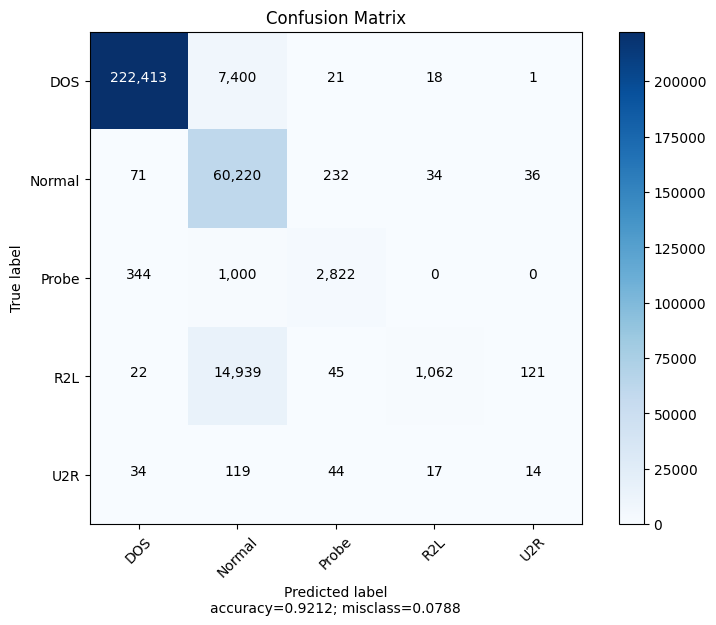

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


confussion_matrix = confusion_matrix(test_labels, predicted_labels, labels=[0, 1, 2, 3, 4])

plot_confusion_matrix(cm=confussion_matrix,
                      normalize=False,
                      target_names=["DOS", "Normal", "Probe", "R2L", "U2R"],
                      title="Confusion Matrix")